<a href="https://colab.research.google.com/github/WiryawanCEO/IndonesianBanknotes-ImageClassificationModel/blob/main/final_model_tl_vgg16_dataset6000_sidangready.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import library dan depedencies yang akan digunakan

In [ ]:
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math

from google.colab import drive
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Buat koneksi dengan Google Drive

In [ ]:
drive.mount('/content/drive')
base = Path('/content/drive/My Drive/')
sys.path.append(str(base))

zip_path = base/'Dataset73.zip'
!cp '{zip_path}' .

!unzip -q Dataset73.zip
!rm Dataset73.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Definisikan direktori dataset di Google Drive, serta setup datagenerator dataset training & validasi

In [ ]:
train_dir = 'Dataset73/train'
validation_dir = 'Dataset73/valid'

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

Masukan dataset kedalam generator berdasarkan batch, kemudian resize ke ukuran 224x224 dengan mode kelas berdasarkan kategorikal

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=100,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=100,
        shuffle=False,
        class_mode='categorical')

Found 4200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.


Buat file labels.txt untuk referensi label kelas di implementasi nantinya sekaligus digunakan pada tahap evaluasi dengan confusion matrix dan classification report

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'100rb': 0, '10rb': 1, '20rb': 2, '2rb': 3, '50rb': 4, '5rb': 5}


Import model pre-trained VGG16 dari keras.applications(), tentukan input shapenya menjadi 224x224, instruksikan untuk tidak menggunakan lapisan akhir model, dan pilih wightsnya ImageNet

In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


Freeze lapisan-lapisan yang ada di model pre-trained VGG16

In [ ]:
base_model.trainable = False

Buat dan gabungkan lapisan fully connected yang dibuat dengan model pre-trained yang sudah di bekukan

In [ ]:
model_fine = tf.keras.models.Sequential()
model_fine.add(base_model)
model_fine.add(tf.keras.layers.Flatten())
model_fine.add(tf.keras.layers.Dense(6, activation='softmax'))

model_fine.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 6)                 150534    
Total params: 14,865,222
Trainable params: 150,534
Non-trainable params: 14,714,688
_________________________________________________________________


Konfigurasi parameter pelatihan dan mulai proses training-nya

In [ ]:
model_fine.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['categorical_accuracy'])

history = model_fine.fit(
      train_generator,
      steps_per_epoch=42,  # 4200 images = batch_size * steps
      epochs=20,
      validation_data=validation_generator,
      validation_steps=18,  # 1800 images = batch_size * steps
      verbose=1)

Epoch 1/20
42/42 [==============================] - 65s 2s/step - loss: 1.7102 - categorical_accuracy: 0.2840 - val_loss: 1.5567 - val_categorical_accuracy: 0.4411
Epoch 2/20
42/42 [==============================] - 65s 2s/step - loss: 1.4305 - categorical_accuracy: 0.5164 - val_loss: 1.4067 - val_categorical_accuracy: 0.4872
Epoch 3/20
42/42 [==============================] - 66s 2s/step - loss: 1.2360 - categorical_accuracy: 0.6467 - val_loss: 1.2355 - val_categorical_accuracy: 0.6256
Epoch 4/20
42/42 [==============================] - 65s 2s/step - loss: 1.0945 - categorical_accuracy: 0.7279 - val_loss: 1.1204 - val_categorical_accuracy: 0.6911
Epoch 5/20
42/42 [==============================] - 65s 2s/step - loss: 0.9760 - categorical_accuracy: 0.7879 - val_loss: 1.0345 - val_categorical_accuracy: 0.7250
Epoch 6/20
42/42 [==============================] - 66s 2s/step - loss: 0.8788 - categorical_accuracy: 0.8331 - val_loss: 0.9647 - val_categorical_accuracy: 0.7478
Epoch 7/20
42/42

Evaluasi hasil pelatihan dengan grafik visualisasi proses training

Text(0.5, 1.0, 'Training and validation loss')

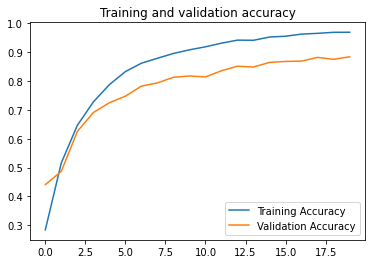

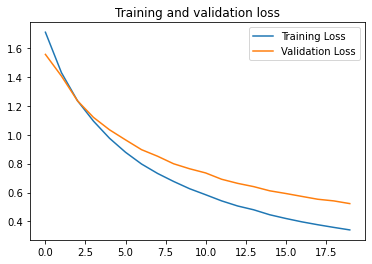

In [ ]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = 'Training Accuracy')
plt.plot(epochs, val_acc, label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = 'Training Loss')
plt.plot(epochs, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

Evaluasi akurasi akhir model pada kumpulan dataset validasi

In [ ]:
validation_generator.reset()
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size
model_fine.evaluate(validation_generator, steps=STEP_SIZE_VALID)

18/18 [==============================] - 18s 1s/step - loss: 0.5232 - categorical_accuracy: 0.8844


[0.5231653451919556, 0.8844444155693054]

Definisikan plotting confusion matrix terlebih dahulu

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Evaluasi klasifikasi dengan menggunakan confusion matrix

Confusion matrix, without normalization
[[277   3   3   0   1  16]
 [  6 233   9  19   8  25]
 [  0   4 276   9   4   7]
 [  4   6   3 260   0  27]
 [  4   8   2   1 281   4]
 [  9  11   2  10   3 265]]
Normalized confusion matrix
[[0.92 0.01 0.01 0.   0.   0.05]
 [0.02 0.78 0.03 0.06 0.03 0.08]
 [0.   0.01 0.92 0.03 0.01 0.02]
 [0.01 0.02 0.01 0.87 0.   0.09]
 [0.01 0.03 0.01 0.   0.94 0.01]
 [0.03 0.04 0.01 0.03 0.01 0.88]]


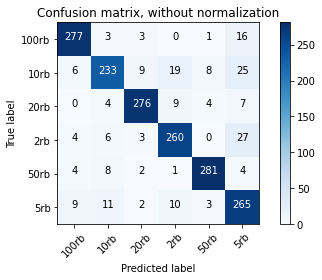

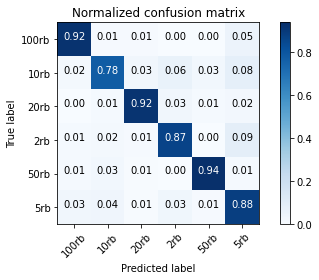

In [ ]:
validation_generator.reset()
Y_pred = model_fine.predict(validation_generator, steps=STEP_SIZE_VALID)
y_pred = np.argmax(Y_pred, axis=1)
target_names = !cat labels.txt

cm = confusion_matrix(validation_generator.classes, y_pred)

# Compute confusion matrix
cnf_matrix = cm
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True, title='Normalized confusion matrix')

plt.show()

Evaluasi klasifikasi dengan laporan klasifikasi (classification report)

In [ ]:
print('Classification Report')
target_names = !cat labels.txt
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

       100rb       0.92      0.92      0.92       300
        10rb       0.88      0.78      0.82       300
        20rb       0.94      0.92      0.93       300
         2rb       0.87      0.87      0.87       300
        50rb       0.95      0.94      0.94       300
         5rb       0.77      0.88      0.82       300

    accuracy                           0.88      1800
   macro avg       0.89      0.88      0.88      1800
weighted avg       0.89      0.88      0.88      1800



Simpan model dan konversikan kedalam format TensorFlow Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_fine)
tflite_model = converter.convert()
open ("final_tl_vgg16_dataset73.tflite" , "wb") .write(tflite_model)

59466896